 ### Introduction

 This dataset is from the Stanford Network Analysis Project. It consists of customer reviews of 
 food products sold at Amazon.
 
 The following description is copied from 
 https://snap.stanford.edu/data/web-FineFoods.html:

     This dataset consists of reviews of fine foods from Amazon.
     The data span a period of more than 10 years, including all ~500,000
     reviews up to October 2012. Reviews include product and user information,
     ratings, and a plaintext review.
   
Each review contains a number of fields, including IDs of the product and the reviewer, as well as a
score assigned to the product by the reviewer. The review score ranges from 1 to 5, with higher scores
implying more favorable reviews.

This is a 2-mode network. We transform it into a 1-mode network for analysis.

In [101]:
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
from networkx import algorithms
import collections

## Import bi-partite (bi-modal) functions
from networkx.algorithms import bipartite as bi

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

### Read text file

The file contains about 5M lines. In this project we use only one-fifth of the file.
We form graphs for user products reviews, and also two additional graphs that include
only those reviews that gave a high rating score (>= 4/5) and low ratings score (<= 1/5).

In [102]:
li = 0
Products = list()
Users = list()

gg = nx.Graph()

# Like == score is >= 4
likes = nx.Graph()
# Dislike == score is <= 1
dislikes = nx.Graph()

Users_likes = list()
Users_dislikes = list()

with open("data/finefoods.txt", "r", encoding="latin-1") as myfile:
    while True:
        li = li + 1
        if li > 1000000:
            break
        entry = [None] * 4
        for i in range(0, 9):
            i1 = i2 = i3 = i4 = -1
            myline = myfile.readline()
            if not myline:
                break
            i1 = myline.find("product/productId: ")
            if i1 != -1:
                prod = myline[i1 + 1 + 18:]
                entry[0] = prod.rstrip()
                continue
            i2 = myline.find("review/userId: ")
            if i2 != -1:
                user = myline[i2 + 1 + 14:]
                entry[1] = user.rstrip()
                continue
            i3 = myline.find("review/helpfulness: ")
            if i3 != -1:
                helpfulness = myline[i3 + 1 + 19:]
                entry[2] = helpfulness
                continue
            i4 = myline.find("review/score: ")
            if i4 != -1:
                score = math.floor(float(myline[i4 + 1 + 13:]))
                entry[3] = score
                continue
            li = li + 1

        if entry[3] is None:
            break
        else:
            entry = [None] * 4
            if prod not in Products:
                Products.append(prod)
            if user not in Users:
                Users.append(user)
                if score >= 4:
                    Users_likes.append(user)
                    likes.add_edge(user, prod, weight=score)
                if score <= 1:
                    Users_dislikes.append(user)
                    dislikes.add_edge(user, prod, weight=score)
            gg.add_edge(user, prod, weight=score)


print("lines = {0}" .format(li))

lines = 1000003


In [151]:
# Nodes here includes both users and products (since gg is not a bipartite graph)
print("Number of nodes: {0}" .format(gg.number_of_nodes()))
print("Number of edges: {0}" .format(gg.number_of_edges()))

print("Number of users: {0}" .format(len(Users)))
print("Number of products: {0}" .format(len(Products)))

Number of nodes: 127940
Number of edges: 164281
Number of users: 106629
Number of products: 21311


In [142]:
### User networks

# A projection of a bipartite graph is a graph of nodes from one partition, where
# each edge between nodes implies a common neighbor in the other partition.

# In this case, two users are connected if they have reviewed a common product.
Unet = bi.weighted_projected_graph(gg, Users, ratio=False)

### Product networks
Pnet = bi.weighted_projected_graph(gg, Products, ratio=False)

In [143]:
Unet.number_of_edges()
Unet.number_of_nodes()
Pnet.number_of_edges()
Pnet.number_of_nodes()

5605094

106629

150057

21311

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


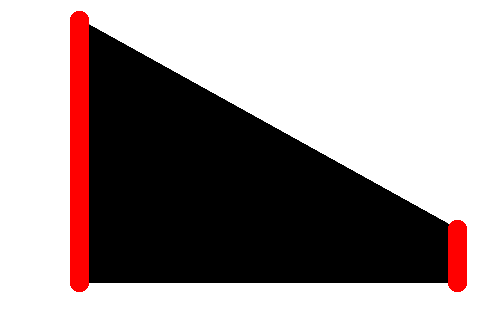

In [144]:
# Update position for node from each group
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(Users))
pos.update((node, (2, index)) for index, node in enumerate(Products))

nx.draw(B, pos=pos)
plt.show()

We now reduce the size of the graphs to include only extreme values of rating scores. Rating scores
range from 1 to 5. We can define a network **Likes** based on scores of 4 or above, and **Dislikes** based
on scores of 1 or below.

In [114]:
# Like == score is >= 4
Unet_likes = bi.weighted_projected_graph(likes, Users_likes, ratio=False)

# Dislike == score is <= 1
Unet_dislikes = bi.weighted_projected_graph(dislikes, Users_dislikes, ratio=False)

In [149]:
print("Main Graph: nodes={0} edges={1}" .format(Unet.number_of_nodes(), Unet.number_of_edges()))
print("High Ratings Graph: nodes={0} edges={1}" .format(Unet_likes.number_of_nodes(), Unet_likes.number_of_edges()))
print("Low Ratings Graph: nodes={0} edges={1}" .format(Unet_dislikes.number_of_nodes(), Unet_dislikes.number_of_edges()))

Main Graph: nodes=106629 edges=5605094
High Ratings Graph: nodes=82715 edges=2092704
Low Ratings Graph: nodes=11025 edges=61812


### Clustering coefficient

Clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together.
We compute clustering coefficients for the main graph and the two graphs for high and low ratings.

In [124]:
ac1 = nx.average_clustering(Unet)
ac2 = nx.average_clustering(Unet_likes)
ac3 = nx.average_clustering(Unet_dislikes)

In [140]:
print("Average clustering for User bipartite graph: {0:10.2}" .format(ac1))
print("Average clustering for User bipartite graph for Likes: {0:10.2}" .format(ac2))
print("Average clustering for User bipartite graph for Dislikes: {0:10.2}" .format(ac3))

Average clustering for User bipartite graph:       0.85
Average clustering for User bipartite graph for Likes:       0.85
Average clustering for User bipartite graph for Dislikes:       0.57


### Degree Distribution
We plot the degree distribution for the main bipartite graph, as well as the graph for Likes (higher ratings scores) and dislikes (lower ratings scores).

In [129]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

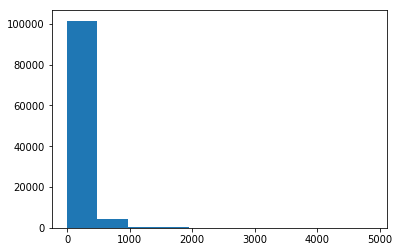

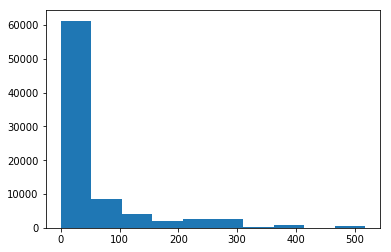

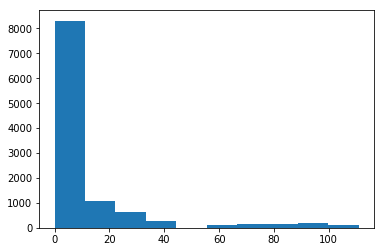

In [131]:
plot_degree_dist(Unet)
plot_degree_dist(Unet_likes)
plot_degree_dist(Unet_dislikes)

### References

1. https://www.coursera.org/lecture/python-social-network-analysis/bipartite-graphs-tWwx2
2. https://networkx.github.io/documentation/stable/reference/index.html